In [206]:
import cv2 as cv
import numpy as np
import random
import copy
from PIL import Image
from image_utils import *
from canvas import *
from scipy import ndimage
from sampling import Sampler
from config import parse_cfg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [209]:
def display(img):
    return Image.fromarray(img)

In [210]:
def get_above_coords(canvas, dot, num_coords):

    top_left_row = num_coords['min_col'] + random.randint(-20, 20)
    top_left_col = num_coords['min_row'] - dot.shape[0] - random.randint(0, 10)

    return top_left_row, top_left_col 

def get_below_coords(canvas, num, dot_coords):
        
    top_left_col = dot_coords['max_row'] + random.randint(0, 10)
    top_left_row = dot_coords['min_col'] + random.randint(-20, 20)
    
    return top_left_row, top_left_col

def get_right_coords(canvas, num, dot_coords):
    
    top_left_col = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_row = dot_coords['max_col'] + random.randint(0, 10)
    
    return top_left_row, top_left_col

def get_left_coords(canvas, num, dot_coords):
    
    top_left_col = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_row = dot_coords['min_col'] - num.shape[1] - random.randint(0, 10)
    
    return top_left_row, top_left_col

def get_yolo_bbox(corners, canvas):
    ''' corners is a tuple of  (top_left, top_right, bot_right, bot_left)'''
    
    x1, y1 = corners[0] #top left
    x2, y2 = corners[2] #bot right
    
    x_mid = (x1 + x2)/2
    y_mid = (y1 + y2) /2
    
    width = x2 - x1
    height = y2 - y1
    
    x_abs = x_mid / canvas.img.shape[1]
    y_abs = y_mid / canvas.img.shape[0]
    
    width_abs = width / canvas.img.shape[1]
    height_abs = height / canvas.img.shape[0]
    
    return x_abs, y_abs, width_abs, height_abs

In [211]:
(3, *(12,32))

(3, 12, 32)

In [213]:
func = [get_above_coords, get_below_coords, get_left_coords, get_right_coords]

canvas_sampler = Sampler(get_canvases('canvases'))
dot_sampler = Sampler(get_img_data('dots'))
background_sampler = Sampler(get_img_data('backgrounds'))
drawing_sampler = Sampler(get_img_data('drawings'))

num_sampler = [None]
a = []
def get_potential_pos(canvas):
    x1 = random.randint(canvas.top_left[0],  canvas.top_right[0])
    y1 = random.randint(canvas.top_left[1],  canvas.bot_left[1])
    
    return x1, y1
    
for i in range(1,3):
    imgs = get_img_data('nums/' + str(i))
    num_sampler.append(Sampler(imgs))

num_of_samples = 2

for img_idx in range(num_of_samples):
    canvas = copy.deepcopy(canvas_sampler.get_sample())
    bboxs = {}

    num_of_drawings = random.randint(0, 3)
    
    for i in range(num_of_drawings):
        drawing = drawing_sampler.get_sample()
        drawing = resize(drawing, .8, 1.3)
        x1, y1 = get_potential_pos(canvas)
        
        while not canvas.draw_on_paper(drawing, (x1, y1), True):
            x1, y1 = get_potential_pos(canvas)


    num_of_nums = random.randint(0, 20)
    
    for i in range(num_of_nums):
        cur_num = random.randint(1,2)
        num = num_sampler[cur_num].get_sample()
        
        num = resize(num, .8, 1.3)

        x1 = random.randint(canvas.top_left[0],  canvas.top_right[0])
        y1 = random.randint(canvas.top_left[1],  canvas.bot_left[1])

        while not canvas.draw_on_paper(num, (x1, y1)):
            x1 = random.randint(canvas.top_left[0],  canvas.top_right[0])
            y1 = random.randint(canvas.top_left[1],  canvas.bot_left[1])

        top_left, top_right, bot_right, bot_left = get_corners((x1, y1), num)
        
        if cur_num not in bboxs:
            bboxs[cur_num] = []
            
        bboxs[cur_num].append((top_left, top_right, bot_right, bot_left))

        num_coords = {}
        num_coords['min_row'] = top_left[1]
        num_coords['max_row'] = bot_right[1]
        num_coords['min_col'] = top_left[0]
        num_coords['max_col'] = bot_right[0]

        np.random.shuffle(func)
        
        scalar = .8   
        dot = dot_sampler.get_sample()
        dot = cv.resize(dot, ( int(dot.shape[0]*scalar), int(dot.shape[1]*scalar)))
        dot = adaptive_thresh(dot)

        for f in func:
            top_left = f(canvas, dot, num_coords)
            if canvas.draw_on_paper(dot, top_left):
                if 0 not in bboxs:
                    bboxs[0] = []
                    
                bboxs[0].append(get_corners(top_left, dot))
                break
    
    deg = np.random.uniform(-15, 15)
    
    org_shape = canvas.img.shape
    canvas.rotate(deg)
    
    rad = np.deg2rad(deg)
    rt = np.array([[np.cos(rad), np.sin(rad)], [-np.sin(rad), np.cos(rad)]])
    
    bbox_str = ''
    for k,v in bboxs.items():
        for obj in v:
            nw = np.dot(rt, np.array(obj).T - (np.array(org_shape[::-1])/2).reshape(2,-1)) + np.array([canvas.img.shape[1]/2, canvas.img.shape[0]/2]).reshape(2,-1)

            nw = nw.astype(np.int32)

            canvas.img = cv.rectangle(canvas.img, tuple(nw[:, 0]), tuple(nw[:, 2]), (0), 1)
            bbox_str += ('%d %f %f %f %f\n' % (k, *get_yolo_bbox(obj, canvas)))
    
    background_count = random.randint(0, 5)
    for i in range(background_count):
 
        background = background_sampler.get_sample()

        background = resize(background, .8, 1.3)

        y1 = random.randint(0, canvas.img.shape[0])
        x1 = random.randint(0, canvas.img.shape[1])

        while canvas.all_corners_inside_paper((x1, y1), background):
            y1 = random.randint(0, canvas.img.shape[0])
            x1 = random.randint(0, canvas.img.shape[1])

        canvas.draw_on_background(background, (x1, y1))
 
        a.append(canvas.img)

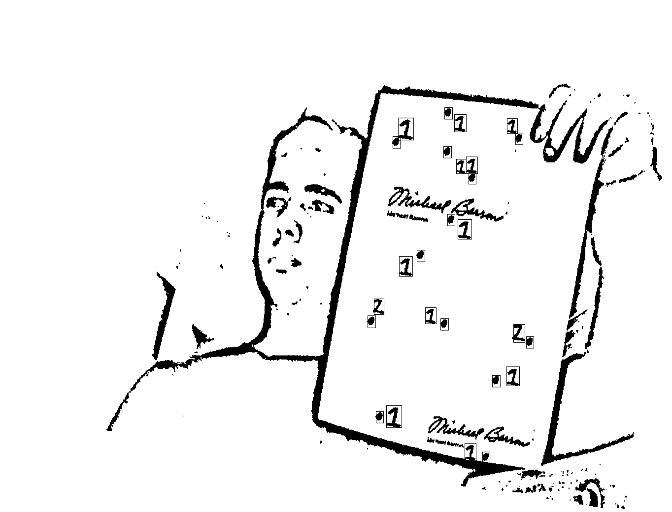

In [219]:
display(cv.resize(image_samples[0], (672, 512)))    

In [177]:
cv.imwrite('m.jpg', image_samples[0])

True